In [2]:
import tensorflow as tf
import numpy as np
import scipy as sp
import scipy.ndimage as spi
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from itertools import *
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import pyprind

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (14,6)

np.random.seed(1)

In [3]:
files = !ls data/train | grep jpg

# Images Size Distribution

In [4]:
shapes = np.asarray([spi.imread('data/train/' + f).shape for f in files])

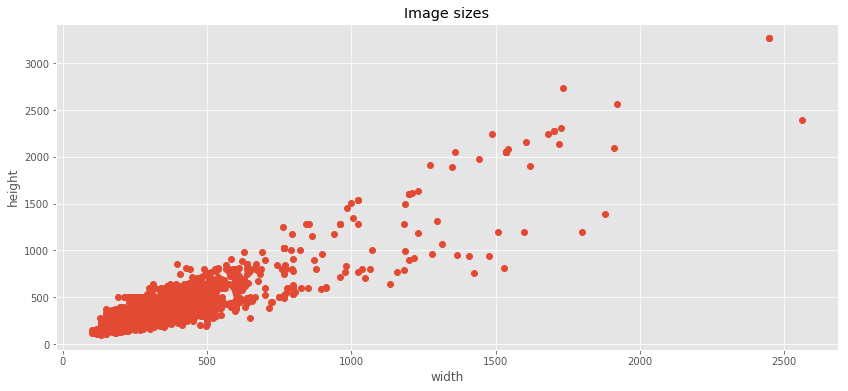

In [5]:
plt.plot(shapes[:, 0], shapes[:, 1], "o")
plt.title("Image sizes")
plt.xlabel("width")
_ = plt.ylabel("height")

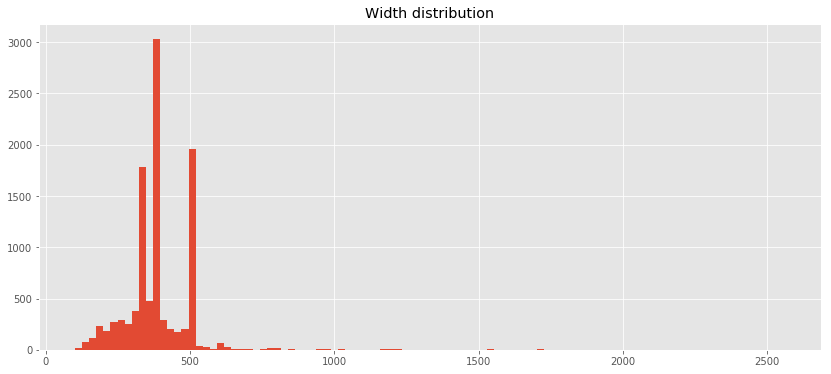

In [6]:
plt.hist(shapes[:, 0], bins=100)
_ = plt.title("Width distribution")

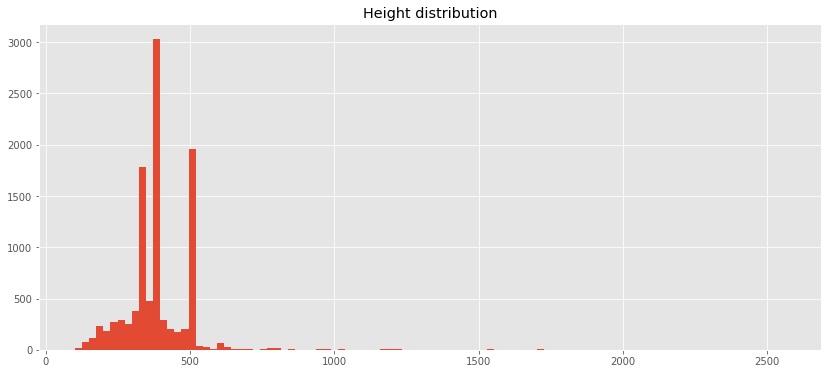

In [7]:
plt.hist(shapes[:, 0], bins=100)
_ = plt.title("Height distribution")

In [8]:
np.mean(shapes[:, 0]), min(shapes[:, 1])

(386.74721189591077, 97)

In [9]:
shapes[:, 0].reshape(1, -1).shape

(1, 10222)

In [10]:
def linearRegression(X, Y, learning_rate = 0.01, epochs = 1000):
    m = X.shape[-1]
    n = 1
    
    graph = tf.Graph()
    
    with graph.as_default():
        
        with tf.name_scope("placeholders"):
            x = tf.placeholder(dtype=tf.float32, shape=(n, None), name="x")
            y = tf.placeholder(dtype=tf.float32, shape=(n, None), name="y")
        
        with tf.name_scope("variables"):
            W = tf.Variable(np.random.randn(1, 1), dtype=tf.float32, name="W")
            b = tf.Variable(np.random.randn(1, 1), dtype=tf.float32, name="b")
    
        with tf.name_scope("linear"):        
            y_pred = W*x + b
        
        with tf.name_scope("cost"):
            cost = tf.reduce_mean(tf.square(y - y_pred))
            tf.summary.scalar('cost', cost)

        with tf.name_scope("optimizer"):
            optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
        
        with tf.Session(graph = graph) as sess:
            writer = tf.summary.FileWriter('dog_breeds/linearRegSummary9', graph = graph)
            merged_summaries = tf.summary.merge_all()
            tf.global_variables_initializer().run()

            for epoch in range(0, epochs):
                _, summary, current_cost, cW, cb = sess.run([optimizer, merged_summaries, cost, W, b], feed_dict={x: X, y: Y})
                
                #if epoch%1000 == 0:
                #    print('%s - %s - %s'%(current_cost, cW, cb))
                
                writer.add_summary(summary, epoch)
                    
                    
            writer.flush()
            writer.close()
        
        return (float(cW), float(cb))

W, b = linearRegression(shapes[:, 0].reshape(1, -1), shapes[:, 1].reshape(1, -1))
W, b

(1.099077582359314, 3.115471601486206)

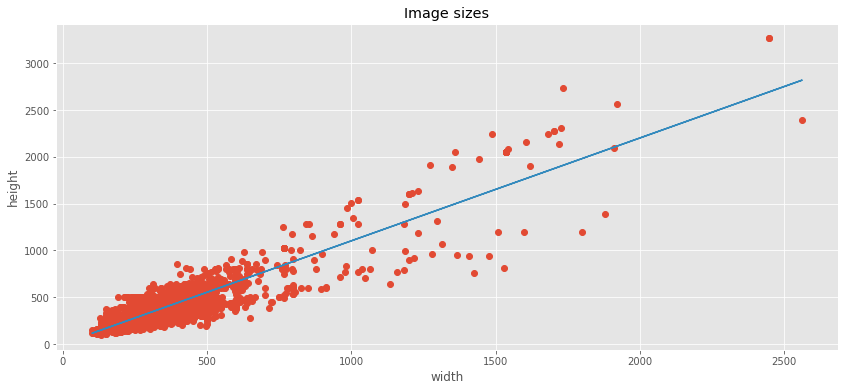

In [11]:
plt.plot(shapes[:, 0], shapes[:, 1], "o")
plt.title("Image sizes")
plt.xlabel("width")
_ = plt.ylabel("height")
plt.plot(shapes[:, 0], W*shapes[:, 0] + b)

In [12]:
numPx = 64
numPy = 64

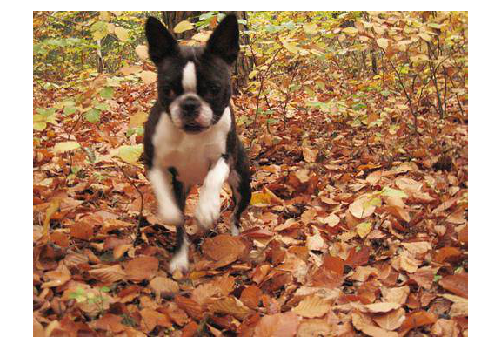

In [13]:
img = plt.imshow(spi.imread('data/train/' + files[0]))
img.set_cmap('hot')
_ = plt.axis('off')

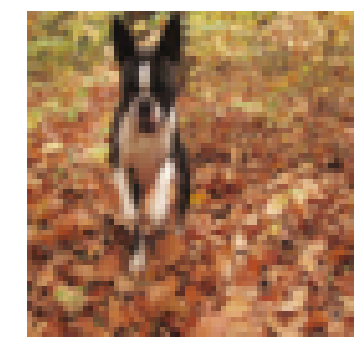

In [14]:
img = plt.imshow(sp.misc.imresize(spi.imread('data/train/' + files[0]), (numPx, numPy)))
img.set_cmap('hot')
_ = plt.axis('off')

# Labels

In [16]:
train_Y_orig = pd.read_csv('data/train/labels.csv', dtype = {'breed': np.str})
labels = train_Y_orig['breed'].unique()

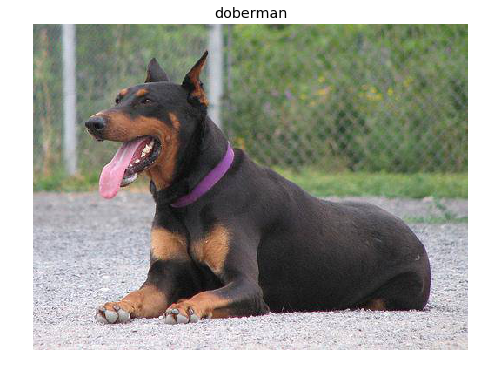

In [18]:
index = 20
label = train_Y_orig.iloc[index]
img = plt.imshow(spi.imread('data/train/' + label.id + '.jpg'))
plt.title(label.breed)
img.set_cmap('hot')
_ = plt.axis('off')
#str(lb.inverse_transform(one_hot_labels[:, index].reshape(1, 120))[0])

In [19]:
lb = preprocessing.LabelBinarizer()
lb.fit(train_Y_orig['breed'])
lb.classes_
Y_train = np.asarray(lb.transform(train_Y_orig['breed']), dtype=np.float32).T
ids = train_Y_orig['id']

In [23]:
def load_batch(ids, Y_train, numPx, numPy, indexes = [], folder="data/train"):
    batch_images = np.stack([sp.misc.imresize(spi.imread(folder + '/' + f + '.jpg'), (numPx, numPy)).reshape(-1) for f in ids[indexes]])
    batch_Y_train = Y_train[:, indexes]
    
    return ((batch_images/255.0).T, batch_Y_train)

In [24]:
def plot_batch(images, one_hot_labels, width, height, numPx, numPy):
    f, ax = plt.subplots(width, height)
    f.set_size_inches(12, 12)
    
    for i in range(0, width):
        for j in range(0, height):
            ax[i][j].axis('off')
            ax[i][j].set_title(str(lb.inverse_transform(one_hot_labels[:, i + j*height].reshape(1, 120))[0]))
            ax[i][j].imshow(images[:, i + j*height].reshape(numPx, numPy, -1))
            
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)

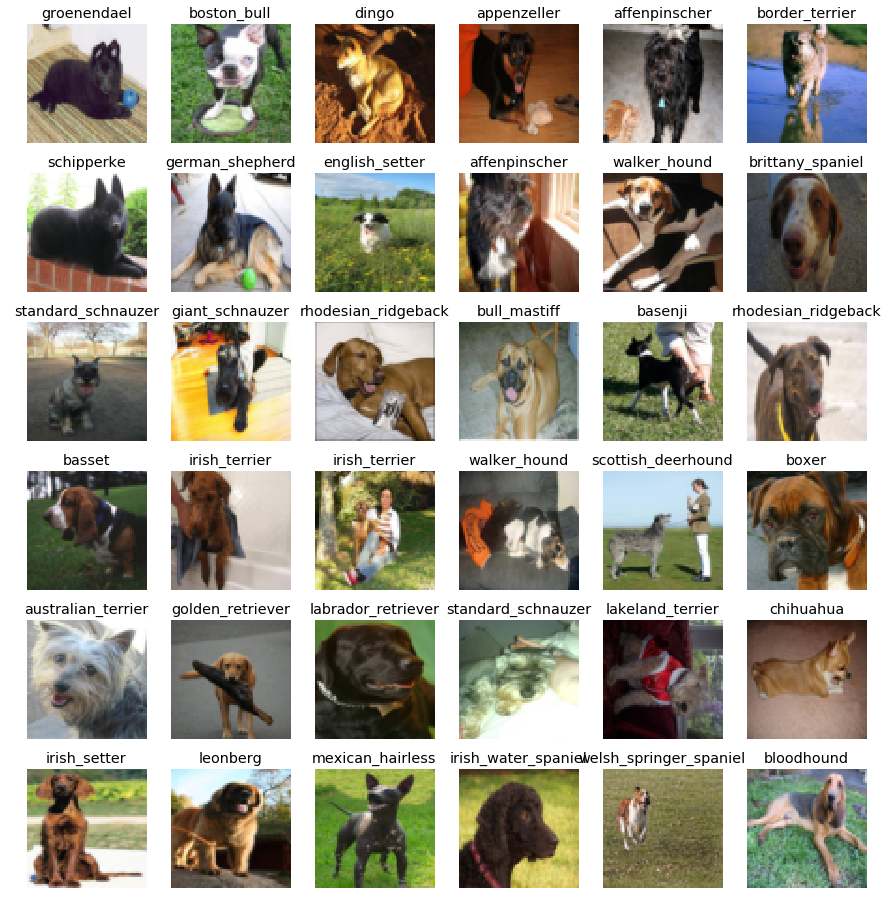

In [25]:
images, one_hot_labels = load_batch(ids, Y_train, numPx=64, numPy=64, indexes = np.random.permutation(np.arange(0, len(Y_train)))[:36])
plot_batch(images, one_hot_labels, 6, 6, 64, 64)

# Logistic Regression

In [5]:
num_test = 1000

ids_train = np.array(ids)[:-num_test]
ids_test = np.array(ids)[-num_test:]

Y_train_train = Y_train[:, :-num_test]
Y_train_test = Y_train[:, -num_test:]

In [58]:
def logisticRegressionModel(layers):
    n_x = layers[0]
    n_y = layers[1]
    
    with tf.name_scope("placeholders"):
        x = tf.placeholder(dtype=tf.float32, shape=(n_x, None), name="x")
        y = tf.placeholder(dtype=tf.float32, shape=(n_y, None), name="y")

    with tf.name_scope("variables"):
        W = tf.Variable(np.random.randn(n_y, n_x)/tf.sqrt(n_x*1.0), dtype=tf.float32, name="W")
        tf.summary.histogram('W', W)
        b = tf.Variable(np.zeros((n_y, 1)), dtype=tf.float32, name="b")
        tf.summary.histogram('b', b)

    with tf.name_scope("linear"):        
        z = tf.matmul(W, x) + b

    with tf.name_scope("cost"):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.transpose(y), logits=tf.transpose(z)))
        tf.summary.scalar('cost', cost)

    with tf.name_scope("inference"):
        probs_pred = tf.nn.softmax(z)
        y_pred = tf.argmax(probs_pred, axis=0)
        y_pred_eq = tf.equal(y_pred, tf.argmax(y, axis=0))
        accuracy = tf.reduce_mean(tf.cast(y_pred_eq, dtype=tf.float32))
        tf.summary.scalar('accuracy', accuracy)
        
    return (cost, x, y, probs_pred)    

In [5]:
def train(graph, cost, x, y, ids, Y_train, numPx=100, numPy=100, learning_rate=0.0001, start_epoch = 0, epochs = 1000, batch_size=256, name="model", restore=False):    
    y_train_indexes = np.arange(0, Y_train.shape[1])
    
    modelPath = "models/" + name + "/" + name + ".ckpt"
    
    bar = pyprind.ProgBar(epochs, bar_char='█', update_interval=1, width = 60)    
    
    with tf.name_scope("optimizer"):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    with tf.Session(graph = graph) as sess:
        writer = tf.summary.FileWriter('dog_breeds/' + name, graph = graph)
        merged_summaries = tf.summary.merge_all()
        tf.global_variables_initializer().run()
        
        if restore:
            saver = tf.train.Saver()
            saver.restore(sess, modelPath)
            
        saver = tf.train.Saver()

        for epoch in range(start_epoch, start_epoch + epochs):
            batch_perm = np.random.permutation(y_train_indexes)[:batch_size]

            #print(batch_perm)
            images, one_hot_labels = load_batch(ids, Y_train, indexes = batch_perm, numPx=numPx, numPy=numPy)

            _, summary, current_cost = sess.run([optimizer, merged_summaries, cost], feed_dict={x: images, y: one_hot_labels})

            #if epoch%10 == 0 or epoch == (epochs + start_epoch):
                #save_path = saver.save(sess, modelPath)
                #test_images, test_labels = load_train_batch(ids_test, Y_train_test, numPx=numPx, numPy=numPy, indexes = np.arange(0, num_test))

            writer.add_summary(summary, epoch)
            bar.update()     

        writer.flush()
        writer.close()
        
        print("Model saved in file: %s" % save_path)
            

In [9]:
def infer(x, probs_pred, test_images, name="model"):    
    modelPath = "models/" + name + "/" + name + ".ckpt"  

    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        
        saver = tf.train.Saver()
        saver.restore(sess, modelPath)
         
        probs_pr = sess.run(probs_pred, feed_dict={x: test_images})
        
    return probs_pr   

In [10]:
numPx = 100
numPy = 100

In [11]:
graph = tf.Graph()
    
with graph.as_default():
    cost, x, y, _ = logisticRegressionModel([numPx*numPy*3, len(labels)])
    train(graph, cost, x, y, ids, Y_train, numPx=100, numPy=100,\
          start_epoch = 0, learning_rate=0.0001, epochs = 1000, batch_size=256, name="logRegModel6", restore=False)    

NameError: name 'logisticRegressionModel' is not defined

In [59]:
graph = tf.Graph()
    
with graph.as_default():
    _, x, y, probs_pred = logisticRegressionModel([numPx*numPy*3, len(labels)])
    test_images, test_labels = load_batch(ids_test, Y_train_test, indexes = np.arange(0, Y_train_test.shape[1]), numPx=numPx, numPy=numPy)
    probs_pr = infer(x, probs_pred, test_images, name="logRegModel5") 
    y_pred_eq = np.equal(np.argmax(probs_pr, axis=0), np.argmax(Y_train_test, axis=0))
    accuracy = np.mean(y_pred_eq) 
    
    print('accuracy=%s'%accuracy)  

INFO:tensorflow:Restoring parameters from models/logRegModel5/logRegModel5.ckpt
accuracy=0.357


# Dense Neural Network

In [61]:
[1, 2, 3, 4][:-1]

[1, 2, 3]

In [6]:
def denseNNModel(layers):
    n_x = layers[0]
    n_y = layers[-1]
    L = len(layers)
    
    with tf.name_scope("placeholders"):
        x = tf.placeholder(dtype=tf.float32, shape=(n_x, None), name="x")
        y = tf.placeholder(dtype=tf.float32, shape=(n_y, None), name="y")

    a = x      
        
    with tf.name_scope("hidden_layers"):
        for l in range(1, len(layers) - 1):
            W = tf.Variable(np.random.randn(layers[l], layers[l-1])/tf.sqrt(layers[l-1]*1.0), dtype=tf.float32, name="W" + str(l))
            tf.summary.histogram('W' + str(l), W)
            b = tf.Variable(np.zeros((layers[l], 1)), dtype=tf.float32, name="b" + str(l))
            tf.summary.histogram('b' + str(l), b)
            z = tf.matmul(W, a) + b
            a = tf.nn.relu(z)
      
    W = tf.Variable(np.random.randn(layers[L-1], layers[L-2])/tf.sqrt(layers[L-2]*1.0), dtype=tf.float32, name="W" + str(L-1))
    tf.summary.histogram('W' + str(L - 1), W)
    b = tf.Variable(np.zeros((layers[L-1], 1)), dtype=tf.float32, name="b" + str(L-1))
    tf.summary.histogram('b' + str(L-1), b)
    z = tf.matmul(W, a) + b

    with tf.name_scope("cost"):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.transpose(y), logits=tf.transpose(z)))
        tf.summary.scalar('cost', cost)

    with tf.name_scope("inference"):
        probs_pred = tf.nn.softmax(z)
        y_pred = tf.argmax(probs_pred, axis=0)
        y_pred_eq = tf.equal(y_pred, tf.argmax(y, axis=0))
        accuracy = tf.reduce_mean(tf.cast(y_pred_eq, dtype=tf.float32))
        tf.summary.scalar('accuracy', accuracy)
        
    return (cost, x, y, probs_pred) 

In [ ]:
numPx = 100
numPy = 110

graph = tf.Graph()
    
with graph.as_default():
    cost, x, y, _ = denseNNModel([numPx*numPy*3, 1024, 512, len(labels)])
    train(graph, cost, x, y, ids, Y_train, numPx=numPx, numPy=numPy,\
          start_epoch = 0, learning_rate=0.0001, epochs=1000, batch_size=1024, name="dense2LayerNN49", restore=False) 

0% [██████████                                                  ] 100% | ETA: 02:57:08

# Test Set

In [15]:
breeds_headers = lb.inverse_transform(np.identity(120))

In [11]:
test_files = !ls test | grep jpg
test_files = np.array([f.replace('.jpg', '') for f in test_files])

In [12]:
def load_test_batch(ids, numPx, numPy, indexes = []):
    batch_images = np.stack([sp.misc.imresize(spi.imread('test/' + str(f) + '.jpg'), (numPx, numPy)).reshape(-1) for f in ids[indexes]])
    
    return (batch_images/255.0).T

In [42]:
graph = tf.Graph()

agg_test_df = None
batch_size = 1000

indexes = np.arange(0, len(test_files))
    
with graph.as_default():
    _, x, y, probs_pred = logisticRegressionModel([numPx*numPy*3, len(labels)], numPx=numPx, numPy=numPy)
    
    for idxs in np.array_split(indexes, len(test_files)/batch_size + 1):
        test_images = load_test_batch(test_files, indexes = idxs, numPx=numPx, numPy=numPy)
        probs_pr = infer(x, probs_pred, test_images, numPx=numPx, numPy=numPy, name="logRegModel5") 

        test_df = pd.DataFrame(data=probs_pr.T, columns=breeds_headers)
        test_df.index = test_files[idxs]

        if agg_test_df is None:
            agg_test_df = test_df
        else:
            agg_test_df = agg_test_df.append(test_df)

INFO:tensorflow:Restoring parameters from models/logRegModel5/logRegModel5.ckpt
INFO:tensorflow:Restoring parameters from models/logRegModel5/logRegModel5.ckpt
INFO:tensorflow:Restoring parameters from models/logRegModel5/logRegModel5.ckpt
INFO:tensorflow:Restoring parameters from models/logRegModel5/logRegModel5.ckpt
INFO:tensorflow:Restoring parameters from models/logRegModel5/logRegModel5.ckpt
INFO:tensorflow:Restoring parameters from models/logRegModel5/logRegModel5.ckpt
INFO:tensorflow:Restoring parameters from models/logRegModel5/logRegModel5.ckpt
INFO:tensorflow:Restoring parameters from models/logRegModel5/logRegModel5.ckpt
INFO:tensorflow:Restoring parameters from models/logRegModel5/logRegModel5.ckpt
INFO:tensorflow:Restoring parameters from models/logRegModel5/logRegModel5.ckpt
INFO:tensorflow:Restoring parameters from models/logRegModel5/logRegModel5.ckpt


In [43]:
agg_test_df.shape

(10357, 120)

In [46]:
agg_test_df.to_csv('logRegModelTest.csv', index_label='id', float_format='%.17f')